<a href="https://colab.research.google.com/github/YugantGotmare/Stock_Trend_Forecast/blob/main/Stock_Trend_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import yfinance as yf
import pandas as pd
import os

In [36]:
df = yf.Ticker("^GSPC")
df = df.history(period="max")
df.index = pd.to_datetime(df.index)
df.index = pd.to_datetime(df.index).date
df = df.rename_axis('Date')

In [37]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0


In [38]:
df.index

Index([1927-12-30, 1928-01-03, 1928-01-04, 1928-01-05, 1928-01-06, 1928-01-09,
       1928-01-10, 1928-01-11, 1928-01-12, 1928-01-13,
       ...
       2023-06-01, 2023-06-02, 2023-06-05, 2023-06-06, 2023-06-07, 2023-06-08,
       2023-06-09, 2023-06-12, 2023-06-13, 2023-06-14],
      dtype='object', name='Date', length=23978)

<Axes: xlabel='Date'>

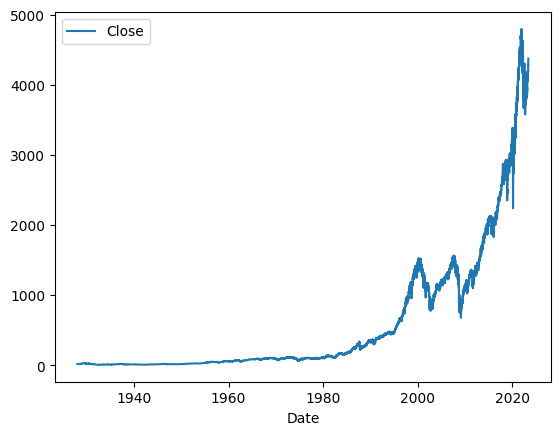

In [39]:
df.plot.line(y="Close", use_index=True)

In [40]:
del df["Dividends"]
del df["Stock Splits"]
del df["Volume"]

In [41]:
df["Tomorrow"] = df["Close"].shift(-1)
df.head()

,Open,High,Low,Close,Tomorrow
Date,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,17.760000
1928-01-03,17.760000,17.760000,17.760000,17.760000,17.719999
1928-01-04,17.719999,17.719999,17.719999,17.719999,17.549999
1928-01-05,17.549999,17.549999,17.549999,17.549999,17.660000
1928-01-06,17.660000,17.660000,17.660000,17.660000,17.500000


In [42]:
df["Target"] = (df["Tomorrow"] > df["Close"]).astype(int)
df.head()

,Open,High,Low,Close,Tomorrow,Target
Date,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,17.760000,1
1928-01-03,17.760000,17.760000,17.760000,17.760000,17.719999,0
1928-01-04,17.719999,17.719999,17.719999,17.719999,17.549999,0
1928-01-05,17.549999,17.549999,17.549999,17.549999,17.660000,1
1928-01-06,17.660000,17.660000,17.660000,17.660000,17.500000,0


In [43]:
start_date = pd.to_datetime("1990-01-01").date()
df = df.loc[start_date:].copy()

In [44]:
df.head()

,Open,High,Low,Close,Tomorrow,Target
Date,,,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002,358.760010,0
1990-01-03,359.690002,360.589996,357.890015,358.760010,355.670013,0
1990-01-04,358.760010,358.760010,352.890015,355.670013,352.200012,0
1990-01-05,355.670013,355.670013,351.350006,352.200012,353.790009,1
1990-01-08,352.200012,354.239990,350.540009,353.790009,349.619995,0


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8428 entries, 1990-01-02 to 2023-06-14
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Open      8428 non-null   float64
 1   High      8428 non-null   float64
 2   Low       8428 non-null   float64
 3   Close     8428 non-null   float64
 4   Tomorrow  8427 non-null   float64
 5   Target    8428 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 460.9+ KB


In [46]:
df.isnull().sum()

Open        0
High        0
Low         0
Close       0
Tomorrow    1
Target      0
dtype: int64

In [47]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = df.iloc[:-100]
test = df.iloc[-100:]

predictors = ["Close", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [48]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5882352941176471

<Axes: xlabel='Date'>

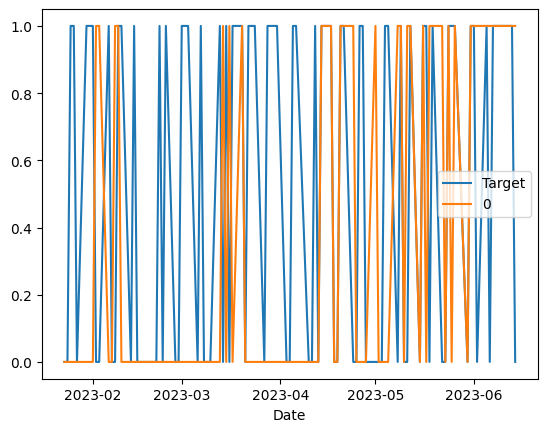

In [49]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [50]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [51]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [52]:
predictions = backtest(df, model, predictors)

In [53]:
predictions["Predictions"].value_counts()

0    3319
1    2609
Name: Predictions, dtype: int64

In [54]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5293215791490993

In [55]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.534076
0    0.465924
Name: Target, dtype: float64

In [56]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = df.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    df[ratio_column] = df["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    df[trend_column] = df.shift(1).rolling(horizon).sum()["Target"]

    new_predictors+= [ratio_column, trend_column]

In [57]:
df.head()

,Open,High,Low,Close,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002,358.760010,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,359.690002,360.589996,357.890015,358.760010,355.670013,0,0.998706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,358.760010,358.760010,352.890015,355.670013,352.200012,0,0.995675,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,355.670013,355.670013,351.350006,352.200012,353.790009,1,0.995098,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,352.200012,354.239990,350.540009,353.790009,349.619995,0,1.002252,1.0,0.993731,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
df = df.dropna(subset=df.columns[df.columns != "Tomorrow"])

In [59]:
df.head()

,Open,High,Low,Close,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,
1993-12-14,465.730011,466.119995,462.459991,463.059998,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15,463.059998,463.690002,461.839996,461.839996,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16,461.859985,463.980011,461.859985,463.339996,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17,463.339996,466.380005,463.339996,466.380005,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20,466.380005,466.899994,465.529999,465.850006,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0


In [60]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [61]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [62]:
predictions = backtest(df, model, new_predictors)

In [63]:
predictions["Predictions"].value_counts()

0.0    4114
1.0     814
Name: Predictions, dtype: int64

In [64]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5687960687960688

In [65]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.544034
0    0.455966
Name: Target, dtype: float64

In [66]:
predictions

,Target,Predictions
Date,,
2003-11-14,0,0.0
2003-11-17,0,1.0
2003-11-18,1,1.0
2003-11-19,0,0.0
2003-11-20,1,1.0
...,...,...
2023-06-08,1,0.0
2023-06-09,1,0.0
2023-06-12,1,0.0


In [79]:
from xgboost import XGBClassifier

model2 = XGBClassifier()

In [80]:
def predict(train, test, predictors, model):
    model2.fit(train[predictors], train["Target"])
    preds = model2.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [81]:
predictions2 = backtest(df, model2, new_predictors)

In [72]:
predictions2["Predictions"].value_counts()

0.0    3024
1.0    1904
Name: Predictions, dtype: int64

In [74]:
precision_score(predictions2["Target"], predictions2["Predictions"])

0.5467436974789915

In [75]:
predictions2["Target"].value_counts() / predictions2.shape[0]

1    0.544034
0    0.455966
Name: Target, dtype: float64